In [2]:
import pandas as pd
import numpy as np

def recall_from_pr_df(pr_df, precision_value=0.75):
    recalls_dict = {}
    classes = pr_df.family.unique()

    for cls in classes:
        cls_pr = pr_df[pr_df.family == cls]
        bins = cls_pr.range.unique()
        recalls_dict[cls] = {}

        for bin in bins[:-1]:
            cls_bin_pr = cls_pr[cls_pr.range == bin]
            precisions = cls_bin_pr.precision.values  # [2:-2]
            recalls = cls_bin_pr.recall.values  # [2:-2]

            # Sort by recalls
            sorted_indices = np.argsort(recalls)[::-1]
            precisions = precisions[sorted_indices]
            recalls = recalls[sorted_indices]

            # Traverse through sorted values and apply the new logic
            
            for i in range(len(precisions)):
                if precisions[i] >= precision_value:
                    if i == 0:
                        recall = recalls[i]
                    else:
                        recall = np.interp(
                            precision_value,
                            [precisions[i-1], precisions[i]],
                            [recalls[i-1], recalls[i]]
                        )
                    break
            else:
                # If no precision meets the target, use the last available recall
                recall = recalls[-1]

            recalls_dict[cls][bin] = recall

    return recalls_dict

In [6]:
data_dict = {'default_600_crop_01_lr_01_wd' : 8,
             'default_600_crop_01_lr_01_wd_20_peds_data' : 9,
             'default_600_crop_01_lr_01_wd_20_peds_data_loss_weight' : 9,
             'default_600_crop_01_lr_01_wd_20_peds_data_loss_weight_v2' : 2,
             #'default_600_crop_01_lr_20_peds_data' : 8
             }

pr = {}

for name, num_ep in data_dict.items():
    print (name, num_ep)
    pr[name] = [pd.read_csv(f"/home/b2b/arthur/git/codetr/work_dirs/{name}/NewEval_ep{i}/outputs/all_kpis.tsv", sep = '\t') for i in range(num_ep)]




default_600_crop_01_lr_01_wd 8
default_600_crop_01_lr_01_wd_20_peds_data 9
default_600_crop_01_lr_01_wd_20_peds_data_loss_weight 9
default_600_crop_01_lr_01_wd_20_peds_data_loss_weight_v2 2


In [7]:
target_pr = 0.9

recs = {}

for name, pr_sample in pr.items():
    recs[name] = [recall_from_pr_df(pr_sample[i], precision_value=target_pr) for i in range(len(pr_sample))]


default_600_crop_01_lr_01_wd_20_peds_data_loss_weight_ep1
default_600_crop_01_lr_01_wd_20_peds_data_loss_weight_v2_ep1


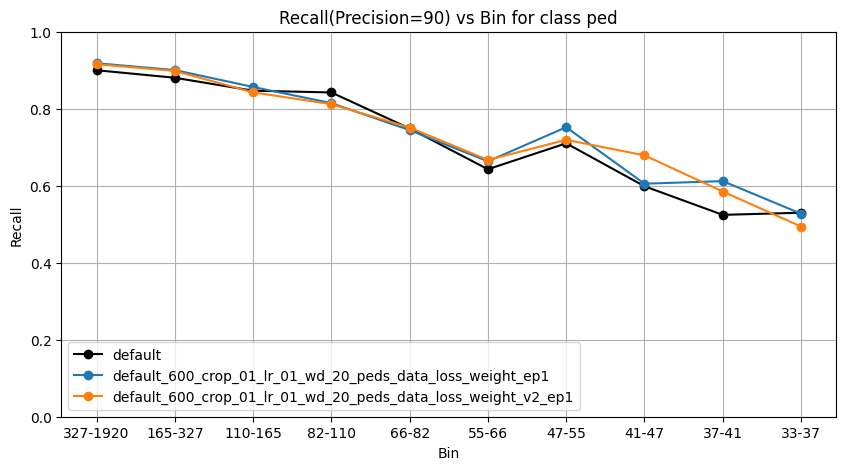

In [8]:
import matplotlib.pyplot as plt

cls = 'ped'


bins = {}
recalls = {}


for name, rec in recs.items():
    bins_data = [rec[i][cls] for i in range(data_dict[name])]
    bins[name] = [bins_data[i].keys() for i in range(data_dict[name])]
    recalls[name] = [bins_data[i].values() for i in range(data_dict[name])]



plt.figure(figsize=(10, 5))

plot_dict = {'default_600_crop_01_lr_01_wd' : [],
             'default_600_crop_01_lr_01_wd_20_peds_data' : [],
             'default_600_crop_01_lr_01_wd_20_peds_data_loss_weight' : [1],
             'default_600_crop_01_lr_01_wd_20_peds_data_loss_weight_v2' : [1],
             #'default_600_crop_01_lr_20_peds_data' : []
             }

plt.plot(bins['default_600_crop_01_lr_01_wd'][0], recalls['default_600_crop_01_lr_01_wd'][0], marker='o', linestyle='-', label = 'default', color = 'black')

for name, indices in plot_dict.items():
    for i in indices:
        label = f'{name}_ep{i}'
        print (label)
        plt.plot(bins[name][i], recalls[name][i], marker='o', linestyle='-', label = label)

plt.xlabel('Bin')
plt.ylabel('Recall')
plt.title(f'Recall(Precision={int(target_pr*100)}) vs Bin for class {cls}')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)

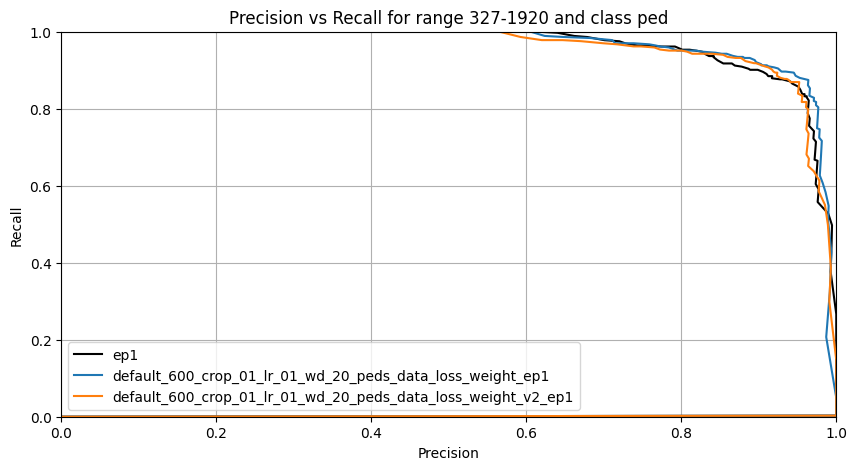

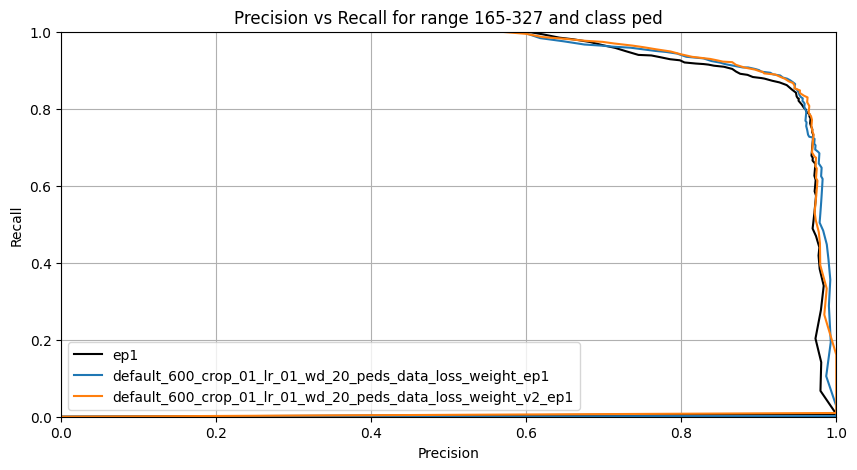

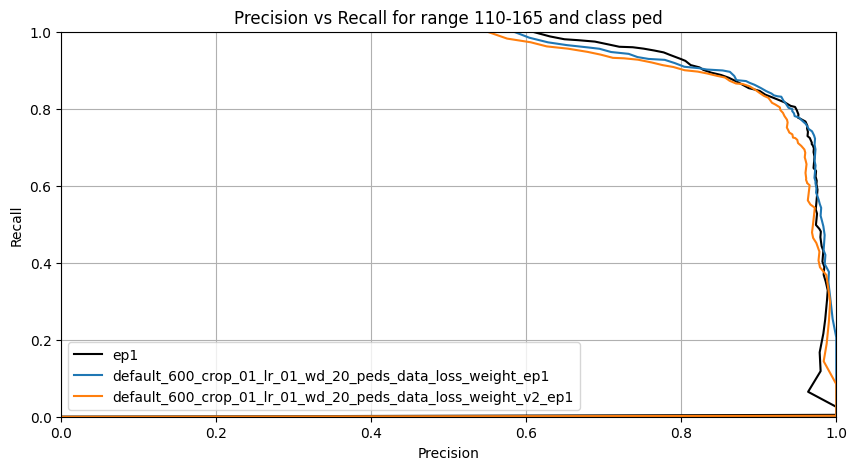

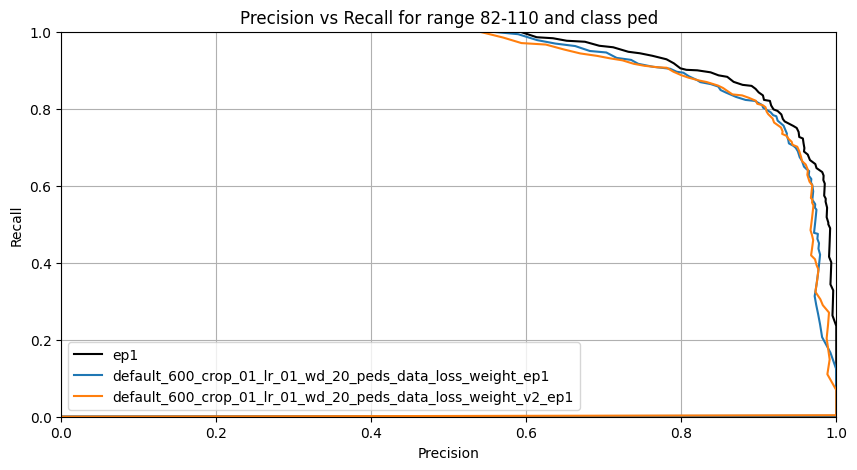

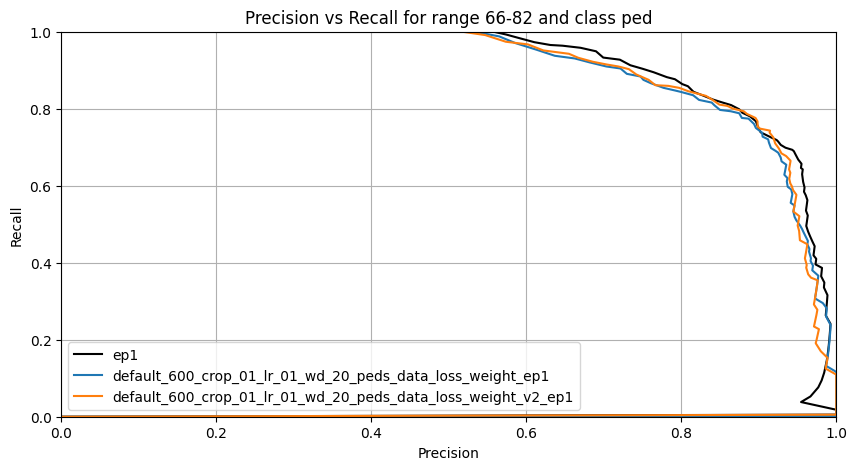

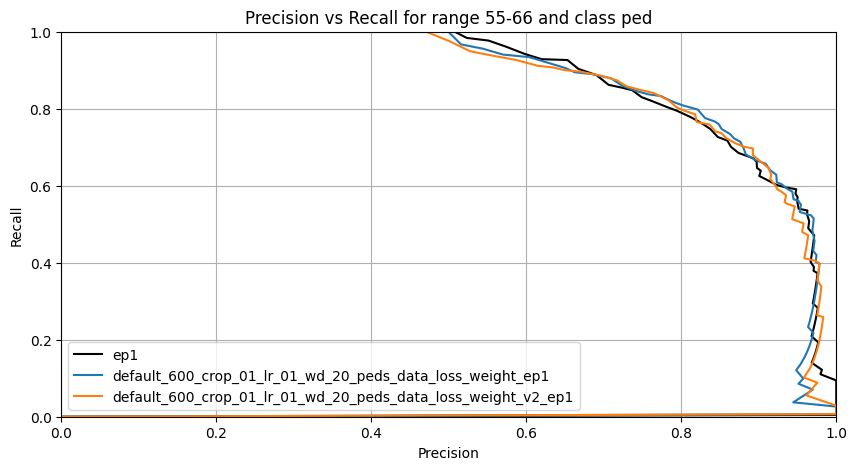

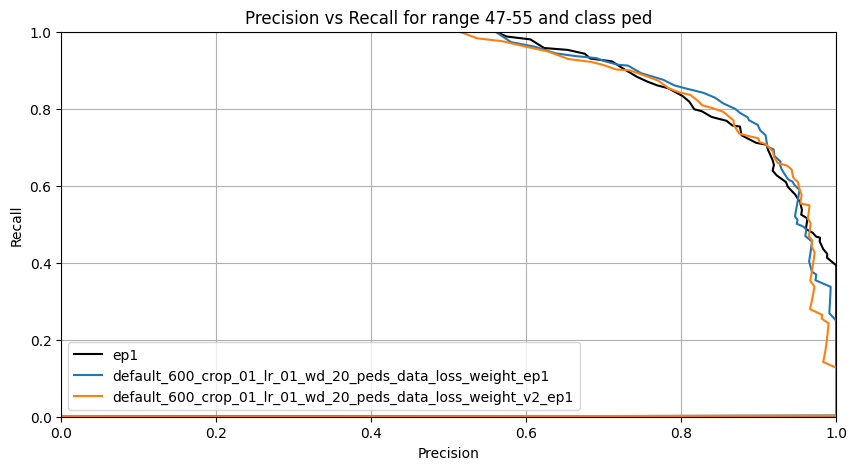

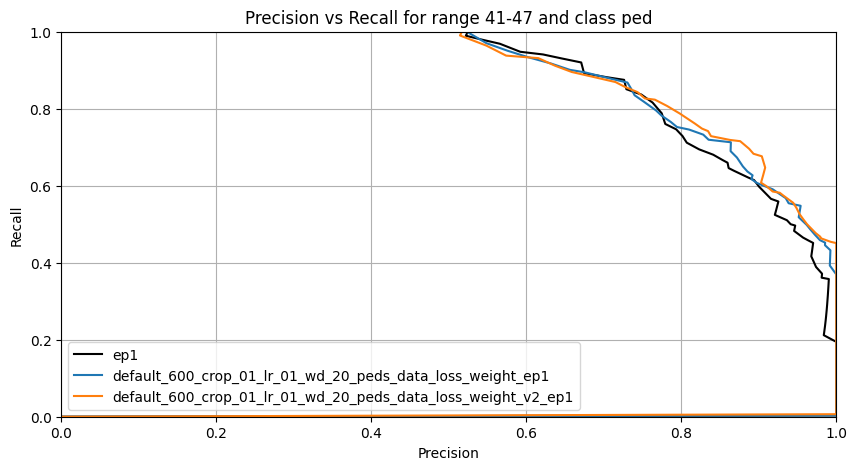

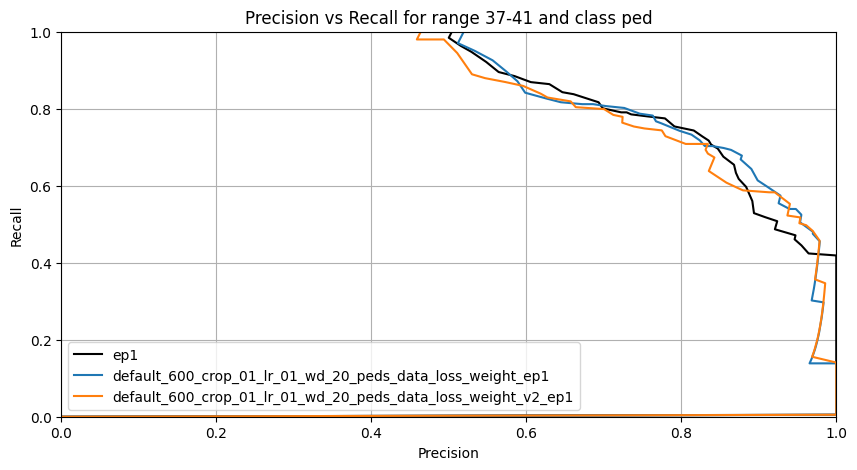

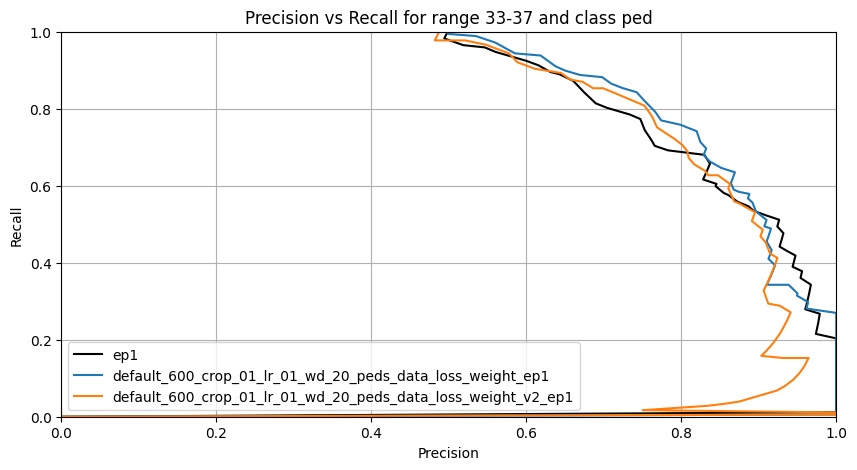

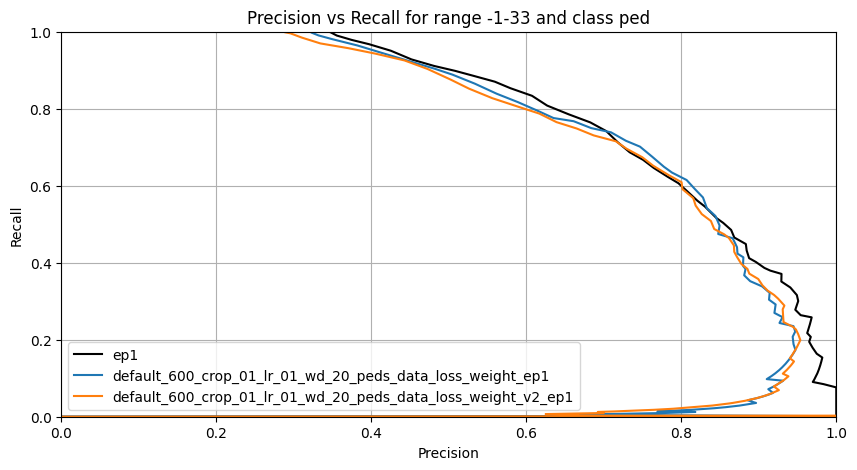

In [9]:


# Extract unique ranges from any experiment (assuming all experiments have the same ranges)
ranges = pr[list(pr.keys())[0]][0][pr[list(pr.keys())[0]][0].family == cls].range.unique()

# Iterate through all ranges
for rng in ranges:
    plt.figure(figsize=(10, 5))  # Create a new figure for each range
    # Iterate through the experiments specified in plot_dict

    name = 'default_600_crop_01_lr_01_wd'
    precisions = pr[name][0][(pr[name][0].range == rng) & (pr[name][0].family == cls)].precision.values
    recalls = pr[name][0][(pr[name][0].range == rng) & (pr[name][0].family == cls)].recall.values
            # Plot Precision vs Recall
    plt.plot(precisions, recalls, label=f'ep{i}', color = 'black')

    for name, indices in plot_dict.items():
        for i in indices:
            # Filter data for the current range and class
            precisions = pr[name][i][(pr[name][i].range == rng) & (pr[name][i].family == cls)].precision.values
            recalls = pr[name][i][(pr[name][i].range == rng) & (pr[name][i].family == cls)].recall.values
            # Plot Precision vs Recall
            plt.plot(precisions, recalls, label=f'{name}_ep{i}')
    
    # Set plot labels and title
    plt.ylabel('Recall')
    plt.xlabel('Precision')
    plt.title(f'Precision vs Recall for range {rng} and class {cls}')
    plt.legend()
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.grid(True)
    plt.show()
